STARTING a variational autoencoder from scratch, should input RGB images
that are 70x70x3 (histopathological imaging)

integrating some functionality from both the tutorial I found. + course DL

TO DO:
* try more deep architecture (+ batch normalization, dropouts)
* add attention layers

In [2]:
# import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
import keras.backend as K
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.model_selection import train_test_split
from glob import glob
import math
%matplotlib inline

In [3]:
def plot_history(history,metric=None):
  fig, ax1 = plt.subplots(figsize=(10, 8))

  epoch_count=len(history.history['loss'])

  line1,=ax1.plot(range(1,epoch_count+1),history.history['loss'],label='train_loss',color='orange')
  ax1.plot(range(1,epoch_count+1),history.history['val_loss'],label='val_loss',color = line1.get_color(), linestyle = '--')
  ax1.set_xlim([1,epoch_count])
  ax1.set_ylim([0, max(max(history.history['loss']),max(history.history['val_loss']))])
  ax1.set_ylabel('loss',color = line1.get_color())
  ax1.tick_params(axis='y', labelcolor=line1.get_color())
  ax1.set_xlabel('Epochs')
  _=ax1.legend(loc='lower left')

  if (metric!=None):
    ax2 = ax1.twinx()
    line2,=ax2.plot(range(1,epoch_count+1),history.history[metric],label='train_'+metric)
    ax2.plot(range(1,epoch_count+1),history.history['val_'+metric],label='val_'+metric,color = line2.get_color(), linestyle = '--')
    ax2.set_ylim([0, max(max(history.history[metric]),max(history.history['val_'+metric]))])
    ax2.set_ylabel(metric,color=line2.get_color())
    ax2.tick_params(axis='y', labelcolor=line2.get_color())
    _=ax2.legend(loc='upper right')

def show_confusion_matrix(conf_matrix,class_names,figsize=(10,10)):
  fig, ax = plt.subplots(figsize=figsize)
  img=ax.matshow(conf_matrix)
  tick_marks = np.arange(len(class_names))
  _=plt.xticks(tick_marks, class_names,rotation=45)
  _=plt.yticks(tick_marks, class_names)
  _=plt.ylabel('Real')
  _=plt.xlabel('Predicted')
  
  for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, '{0:.1%}'.format(conf_matrix[i, j]),
                       ha='center', va='center', color='w')

In [4]:
# import data
imagePatches = glob('datasets/breast-histopathology/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x2251_y1951_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x1951_y2201_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x2001_y2151_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x1901_y2751_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x2201_y2001_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x1501_y2651_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x2201_y2701_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x2051_y2001_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x1701_y2701_class1.png
datasets/breast-histopathology/IDC_regular_ps50_idx5/8864/1/8864_idx5_x2401_y2701_class1.png


In [5]:
class0 = [] # 0 = no cancer
class1 = [] # 1 = cancer

for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

In [6]:
len(class1)

78786

In [7]:
len(class0)

198738

In [8]:
sampled_class0 = random.sample(class0, 78786)
sampled_class1 = random.sample(class1, 78786)
print(len(sampled_class0))
print(len(sampled_class1))

78786
78786


In [9]:
from matplotlib.image import imread
import cv2

def get_image_arrays(data, label):
    img_arrays = []
    for i in data:
        if i.endswith('.png'):
            img = cv2.imread(i ,cv2.IMREAD_COLOR)
            img_sized = cv2.resize(img, (50, 50), #was (70,70)
                        interpolation=cv2.INTER_LINEAR)
            img_arrays.append([img_sized, label]) 
    return img_arrays

In [10]:
class0_array = get_image_arrays(sampled_class0, 0)
class1_array = get_image_arrays(sampled_class1, 1)


In [11]:
#test = cv2.imread('datasets/breast-histopathology/IDC_regular_ps50_idx5/13689/1/13689_idx5_x801_y1501_class1.png', cv2.IMREAD_COLOR)
#test.shape

In [12]:
combined_data = np.concatenate((class0_array, class1_array))
#random.seed(11)
#random.shuffle(combined_data) # sampling was creating unbalanced classes
combined_data.shape


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


(157572, 2)

In [13]:
X = []
y = []

for features, label in combined_data:
    X.append(features)
    y.append(label)


In [14]:
print(y[0:3])

[0, 0, 0]


In [15]:
X = np.array(X).reshape(-1, 50, 50, 3)
y = np.array(y)

print(X.shape)
print(y.shape)

np.average(y)

(157572, 50, 50, 3)
(157572,)


0.5

In [16]:
print(y[0:3])

[0 0 0]


In [17]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2,
                                    random_state = 11)

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, 
                            test_size = 0.25, random_state = 11) 
                            # 0.25 x 0.8 = 0.2
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)
val_y = to_categorical(val_y)
train_y_label = np.argmax(train_y, axis=1) # from one-hot encoding to integer
test_y_label = np.argmax(test_y, axis=1)
val_y_label = np.argmax(val_y, axis=1)
class_names = ('non-cancer','cancer')
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(94542, 50, 50, 3) (31515, 50, 50, 3) (94542, 2) (31515, 2)


In [18]:
print(train_y[0:10])
print(train_y_label[0:10])

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]
[1 1 1 1 1 0 0 0 1 1]


In [19]:
print('Min value: ', train_x.min())
print('Max value: ', train_x.max())

Min value:  0
Max value:  255


In [20]:
train_x = train_x / 255
val_x = val_x / 255
test_x = test_x / 255
print('Min value: ', train_x.min())
print('Max value: ', train_x.max())

Min value:  0.0
Max value:  1.0


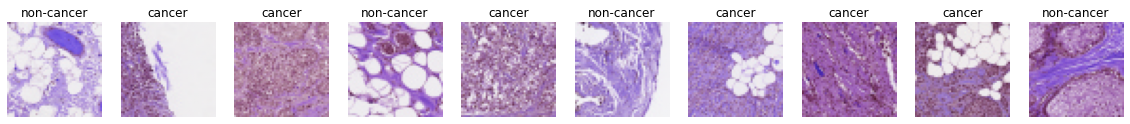

In [21]:
image_count = 10

_, axs = plt.subplots(1, image_count, figsize=(20, 20))
for i in range(image_count):
  random_idx=random.randint(0, train_x.shape[0])
  axs[i].imshow(train_x[random_idx], cmap='gray')
  axs[i].axis('off')
  axs[i].set_title(class_names[train_y_label[random_idx]])

In [22]:
batch_size = 250
input_shape = (50, 50, 3)

In [23]:
def CNN(input_shape=(50, 50, 3), output_class_count=2):
    model=keras.Sequential(
            [
                layers.Input(shape=input_shape,name='Input'),
                layers.Conv2D(filters=6, kernel_size=5, strides=1,padding='valid',name='conv1'),
                layers.BatchNormalization(),
                layers.ReLU(),
                #layers.AvgPool2D(pool_size=2, strides=2,name='S2'),
                layers.MaxPool2D(pool_size=2, strides=2,name='S2'),
                

    # layer 2
                layers.Conv2D(filters=16, kernel_size=5,strides=1,padding='valid',name='conv2'),
                layers.BatchNormalization(),
                layers.ReLU(),
                #layers.AvgPool2D(pool_size=2, strides=2,name='S4'),
                layers.MaxPool2D(pool_size=2, strides=2,name='S4'),
                

    # layer 3
                layers.Conv2D(filters=120, kernel_size=5,strides=1,padding='valid',name='conv3'),
                layers.BatchNormalization(),
                layers.ReLU(),
                layers.Flatten(),
                layers.Dropout(0.1),
                layers.Dense(84, activation='relu',name='F6'),
                layers.Dense(units=output_class_count,activation='softmax',name='Output')

            ]
    )
    return model

In [24]:
base_model = keras.applications.VGG19(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(50, 50, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

base_model.trainable = False

2022-04-09 19:37:23.577565: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
base_model.trainable


False

In [26]:
class ConvBlock(keras.Model):
    def __init__(self, num_filters, kernel_size=(3, 3)):
        super(ConvBlock, self).__init__()

        self.conv = layers.Conv2D(num_filters, kernel_size)
        self.bn = layers.BatchNormalization()
        self.relu = layers.Activation("relu")
        self.pooling = layers.MaxPool2D((2, 2))

    def call(self, x, pool=True):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)

        if pool == True:
            x = self.pooling(x)

        return x

In [27]:
layer_names = [layer.name for layer in base_model.layers][1:]
layer_names = layer_names[0:2]
layer_names
base_model.get_layer('block1_conv1')

In [28]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [29]:
def CNN_blocks(input_shape=(50, 50, 3), output_class_count=2):
            
    inputs = layers.Input(shape=input_shape,name='Input')

    x = base_model.get_layer('block1_conv1')(inputs)
    x.trainable=False

    x = base_model.get_layer('block1_conv2')(x)
    x.trainable=False


    x = ConvBlock(6, kernel_size=(5, 5))(x, pool=False)

# layer 2   
    x= ConvBlock(16, kernel_size=(5, 5))(x,pool=False)
    

# layer 3
    x = ConvBlock(120, kernel_size=(5, 5))(x, pool=False)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(84, activation='relu',name='F6')(x)
    outputs = layers.Dense(units=output_class_count,activation='softmax',name='Output')(x)

    model = keras.Model(inputs, outputs)
    return model

In [30]:
def CNN(input_shape=(50, 50, 3), output_class_count=2):
                
    inputs = layers.Input(shape=input_shape,name='Input')

    x = base_model.get_layer('block1_conv1')(inputs)
    x.trainable=False

    x = base_model.get_layer('block1_conv2')(x)
    x.trainable=False


    x = layers.Conv2D(filters=6, kernel_size=5, strides=1,padding='valid',name='conv1')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.MaxPool2D(pool_size=2, strides=2,name='S2')(x)
    

# layer 2
    x = layers.Conv2D(filters=16, kernel_size=5,strides=1,padding='valid',name='conv2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=2, strides=2,name='S4')(x)
    

# layer 3
    x = layers.Conv2D(filters=120, kernel_size=5,strides=1,padding='valid',name='conv3')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Flatten()(x)

    x = layers.Dropout(0.1)(x)
    x = layers.Dense(84, activation='relu',name='F6')(x)
    outputs = layers.Dense(units=output_class_count,activation='softmax',name='Output')(x)
    
    model = keras.Model(inputs, outputs)
    return model

In [31]:
model = CNN((50, 50, 3), 2)

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 conv1 (Conv2D)              (None, 46, 46, 6)         9606      
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 6)        24        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 46, 46, 6)         0         
                                                             

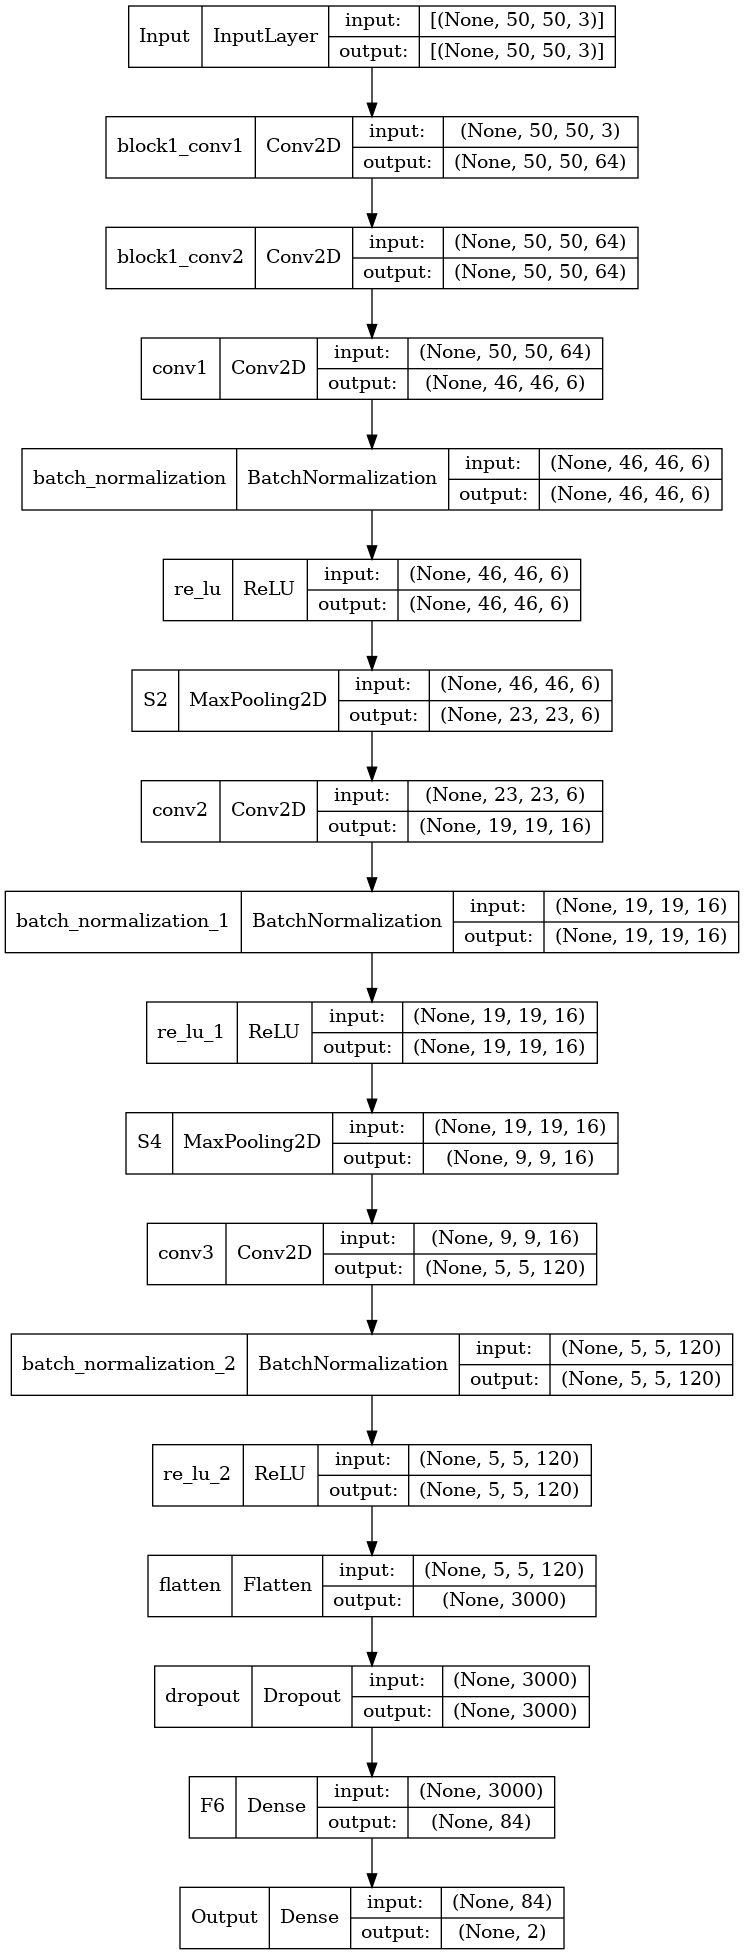

In [33]:
keras.utils.plot_model(model, show_shapes=True)

In [34]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [35]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      f1_score,
]

In [36]:
optimizer=keras.optimizers.Adam()
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=METRICS)

In [37]:
batch_size = 250
epoch_count = 20

history = model.fit(train_x, train_y, batch_size, epoch_count,
         validation_data = (val_x, val_y))

Epoch 1/20
379/379 [==============================] - 245s 643ms/step - loss: 0.4091 - accuracy: 0.8251 - precision: 0.8251 - recall: 0.8251 - auc: 0.8964 - f1_score: 0.8252 - val_loss: 4.4660 - val_accuracy: 0.5005 - val_precision: 0.5005 - val_recall: 0.5005 - val_auc: 0.5002 - val_f1_score: 0.4988
Epoch 2/20
379/379 [==============================] - 241s 637ms/step - loss: 0.3680 - accuracy: 0.8436 - precision: 0.8436 - recall: 0.8436 - auc: 0.9149 - f1_score: 0.8437 - val_loss: 1.0595 - val_accuracy: 0.5689 - val_precision: 0.5689 - val_recall: 0.5689 - val_auc: 0.6666 - val_f1_score: 0.5667
Epoch 3/20
379/379 [==============================] - 241s 636ms/step - loss: 0.3567 - accuracy: 0.8477 - precision: 0.8477 - recall: 0.8477 - auc: 0.9199 - f1_score: 0.8477 - val_loss: 1.4391 - val_accuracy: 0.5812 - val_precision: 0.5812 - val_recall: 0.5812 - val_auc: 0.6263 - val_f1_score: 0.5793
Epoch 4/20
379/379 [==============================] - 241s 636ms/step - loss: 0.3484 - accurac

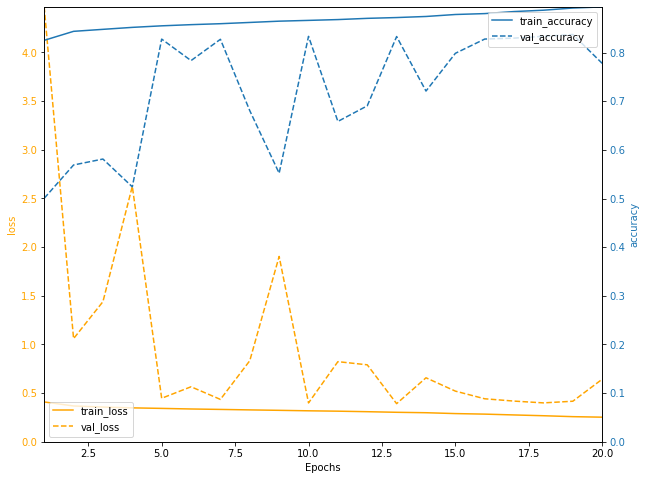

In [38]:
plot_history(history, metric='accuracy')

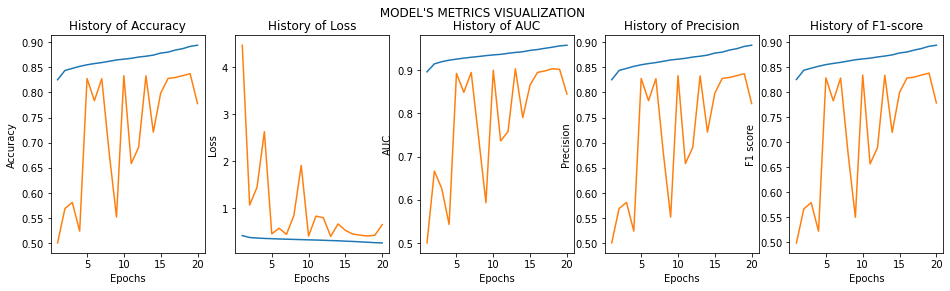

In [39]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (16,4))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    #ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    #ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title(' History of AUC ')
    ax3.set_xlabel(' Epochs ')
    ax3.set_ylabel('AUC')
    #ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    #ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    #ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score'])

In [40]:
#performance on test set
results = model.evaluate(test_x, test_y, batch_size = batch_size, verbose=0)
print('Loss: {:.3f} Accuracy: {:.3f}'.format(results[0], results[1]))

Loss: 0.646 Accuracy: 0.782


In [41]:
test_conf_pred = model.predict(test_x)
print('Output predictions shape: ',test_conf_pred.shape)

Output predictions shape:  (31515, 2)


In [42]:
test_y_pred = np.argsort(test_conf_pred, axis=1)[:,-1]
print('Class predictions shape: ',test_y_pred.shape)

Class predictions shape:  (31515,)


In [43]:
test_conf_pred = model.predict(val_x)
print('Output predictions shape: ',test_conf_pred.shape)

val_y_pred = np.argsort(test_conf_pred, axis=1)[:,-1]
print('Class predictions shape: ',val_y_pred.shape)

Output predictions shape:  (31515, 2)
Class predictions shape:  (31515,)


In [44]:
correct = np.equal(test_y_pred, test_y_label)
accuracy = correct.sum() / len(correct)
print('Test set accuracy: {:.3f}'.format(accuracy))

Test set accuracy: 0.782


[[0.30547358 0.19755672]
 [0.02081548 0.47615421]]


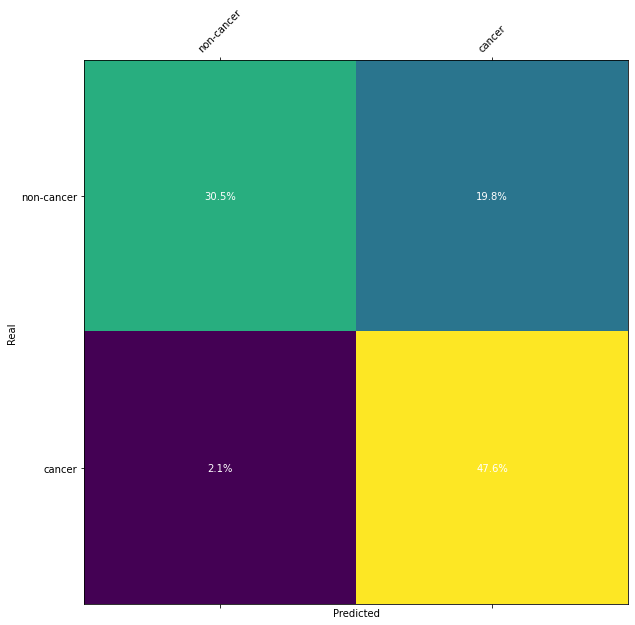

In [45]:
conf_matrix = confusion_matrix(test_y_label, test_y_pred, normalize='all')
print(conf_matrix)
show_confusion_matrix(conf_matrix,class_names)

[[0.60726676 0.39273324]
 [0.04188482 0.95811518]]


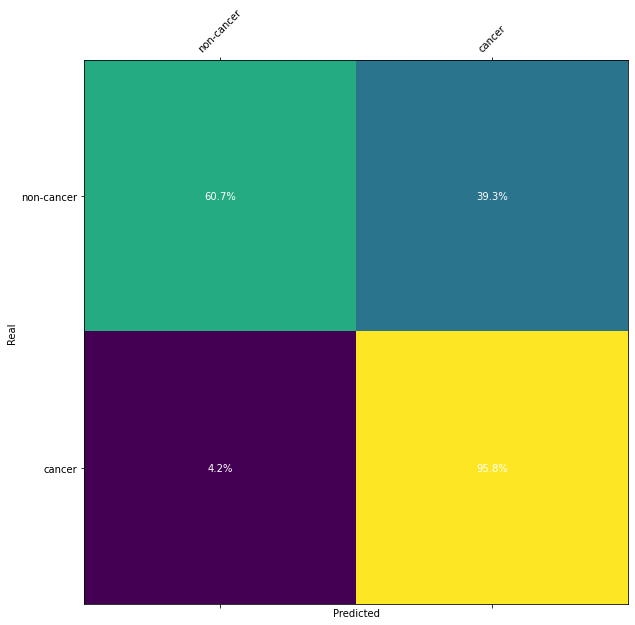

In [46]:
conf_matrix = confusion_matrix(test_y_label, test_y_pred, normalize='true')
print(conf_matrix)
show_confusion_matrix(conf_matrix,class_names)

[[0.5992393  0.4007607 ]
 [0.04326557 0.95673443]]


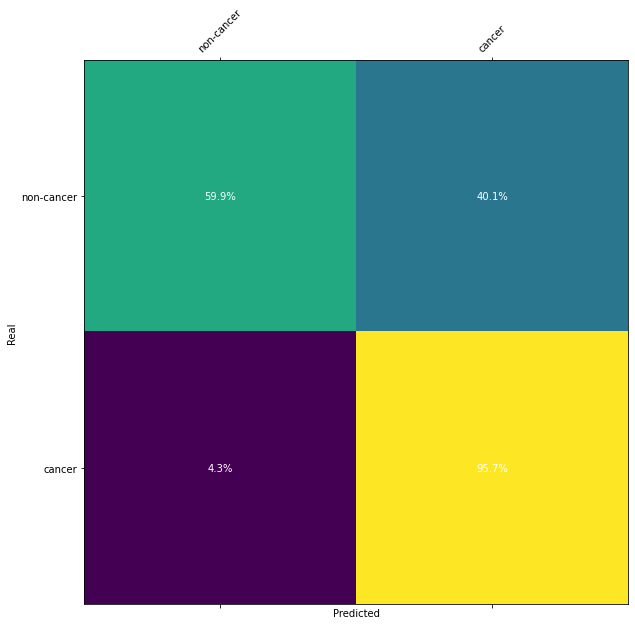

In [47]:
conf_matrix = confusion_matrix(val_y_label, val_y_pred, normalize='true')
print(conf_matrix)
show_confusion_matrix(conf_matrix,class_names)

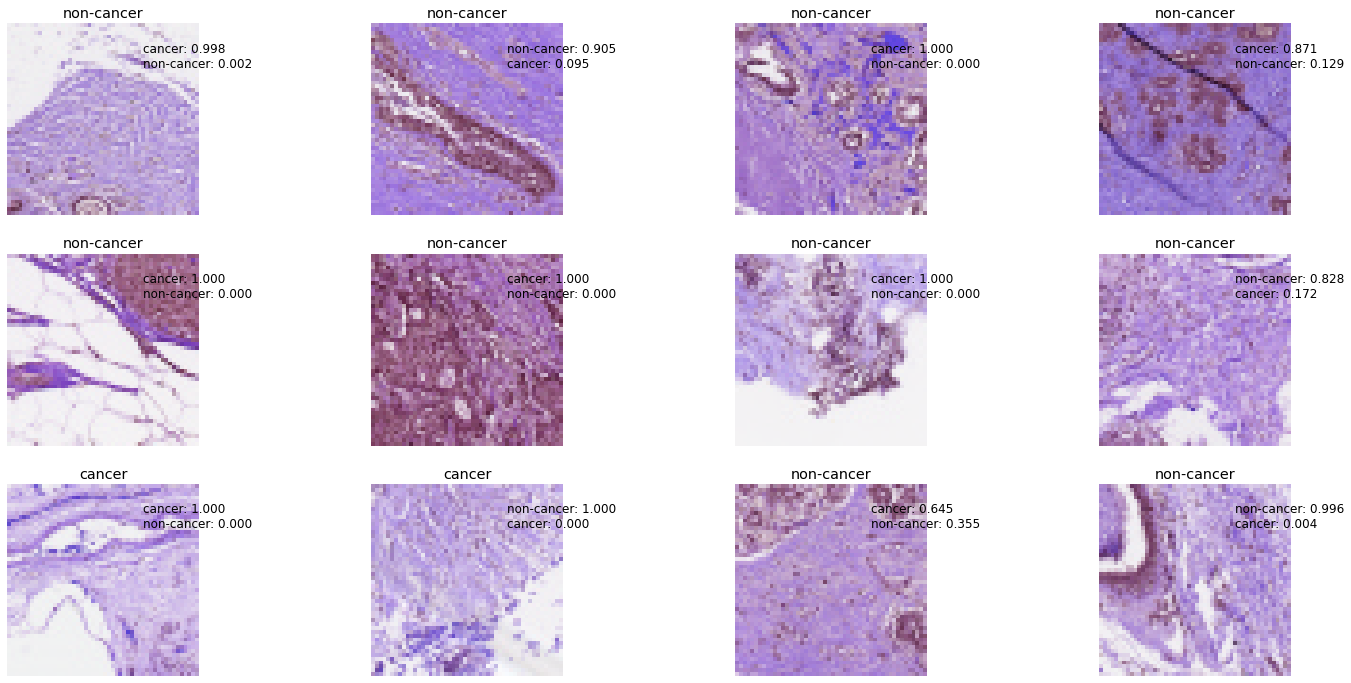

In [48]:
images_to_show = 12

error_indices = np.where(correct == False)[0]

if error_indices.shape[0] > 0:
  image_per_row = 4
  top_class_count = 3

  selected_indices = []
  for i in range(min(images_to_show, error_indices.shape[0])):
    random_idx = random.randint(0, error_indices.shape[0])
    selected_indices.append(random_idx)
  error_indices = error_indices[selected_indices]

  row_count = math.ceil(len(error_indices)/image_per_row)
  column_count = image_per_row
  plt.rcParams.update({'font.size': 12})
  _, axs = plt.subplots(row_count, column_count,figsize=(25, 4*row_count),squeeze=False)

  for i in range(row_count):
    for j in range(column_count):
      axs[i,j].axis('off')

  for i in range(len(error_indices)):
    q = i // image_per_row
    r = i % image_per_row
    idx = error_indices[i]

    axs[q,r].imshow(test_x[idx].squeeze(),cmap='gray')
    axs[q,r].set_title(class_names[test_y_label[idx]])

    sorted_conf_indices=np.argsort(test_conf_pred[idx])
    best_indices=sorted_conf_indices[-top_class_count:]
        
    text=''
    for j in range(len(best_indices)-1,-1,-1):
        text+='{}: {:.3f}\n'.format(class_names[best_indices[j]],test_conf_pred[idx][best_indices[j]])

    axs[q,r].text(35, 10, text, horizontalalignment='left', verticalalignment='center')
plt.show()

In [49]:
#model.save('models/CNN.h5')  
model.save_weights('weights/CNN_weights.h5')  

In [50]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

block1_conv1 (3, 3, 3, 64)
64


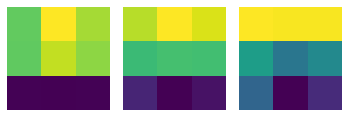

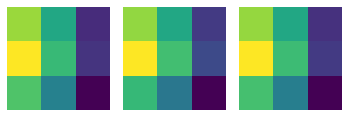

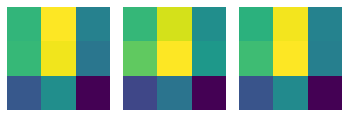

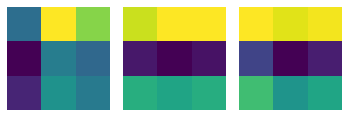

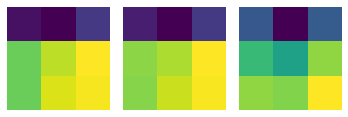

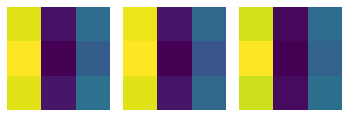

block1_conv2 (3, 3, 64, 64)
64


conv1 (5, 5, 64, 6)
6


conv2 (5, 5, 6, 16)
16


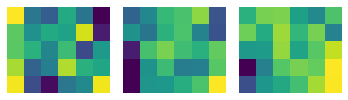

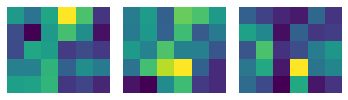

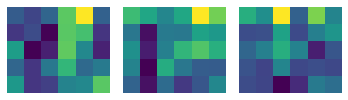

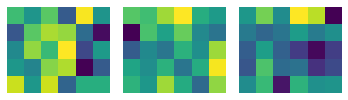

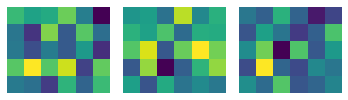

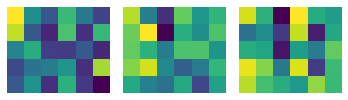

conv3 (5, 5, 16, 120)
120


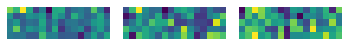

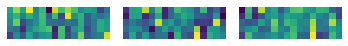

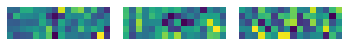

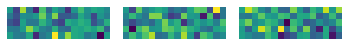

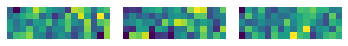

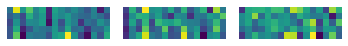

In [53]:
def plotFilters(conv_filter):
    fig, axes = plt.subplots(1, 3, figsize=(5,5))
    axes = axes.flatten()
    for img, ax in zip( conv_filter, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

for layer in model.layers:
    if 'conv' in layer.name:
        filters, bias= layer.get_weights()
        print(layer.name, filters.shape)
         #normalize filter values between  0 and 1 for visualization
        f_min, f_max = filters.min(), filters.max()
        filters = (filters - f_min) / (f_max - f_min)  
        print(filters.shape[3])
        axis_x=1
        #plotting all the filters
        #for i in range(filters.shape[3]):
        for i in range(6):
            #get the filters
            filt=filters[:,:,:, i]
            plotFilters(filt)

block1_conv1 (3, 3, 3, 64)
64


block1_conv2 (3, 3, 64, 64)
64


ValueError: num must be 1 <= num <= 192, not 193

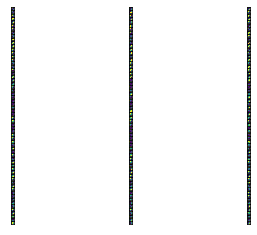

In [54]:
#Visualizing the filters
#plt.figure(figsize=(5,5))
for layer in model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        print(layer.name, weights.shape)
         #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(weights.shape[3])
        filter_cnt=1
        #plotting all the filters
        for i in range(filters.shape[2]):
        #for i in range(6):
            #get the filters
            filt=filters[:,:,:, i]
            #plotting ecah channel
            for j in range(filters.shape[2]):
                #plt.figure( figsize=(5, 5) )
                #f = plt.figure(figsize=(10,10))
                ax= plt.subplot(filters.shape[3], filters.shape[0], filter_cnt  )
                ax.set_xticks([])
                ax.set_yticks([])
                plt.imshow(filt[:,:, j])
                filter_cnt+=1
        plt.show()

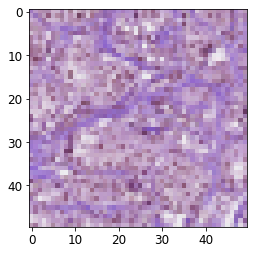

In [55]:
img = train_x[0]
plt.imshow(img)
plt.show()

In [56]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
#x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") at layer "block1_conv1". The following previous layers were accessed without issue: ['block1_conv1']

(1, 50, 50, 3)


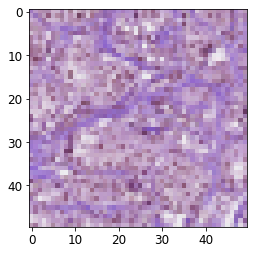

In [57]:
from keras.preprocessing import image
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
print(img_tensor.shape)
plt.imshow(img_tensor[0])
plt.show()

In [58]:
from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[1:]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") at layer "block1_conv1". The following previous layers were accessed without issue: ['block1_conv1']

In [59]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)
len(activations)
first_layer_activation = activations[5]
print(first_layer_activation.shape)

NameError: name 'activation_model' is not defined

In [60]:
import matplotlib.pyplot as plt
num_layers = first_layer_activation.shape[-1]
_, axs = plt.subplots(1, num_layers, figsize=(20, 20))
for i in range(num_layers):
    
    axs[i].imshow(first_layer_activation[0, :, :, i])
    

NameError: name 'first_layer_activation' is not defined

In [ ]:
layer_names = [layer.name for layer in model.layers]
layer_names

In [61]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[1:]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    #plt.savefig(layer_name)
    
plt.show()

NameError: name 'activations' is not defined